In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
#sns.set_palette("Set1")
import warnings
warnings.filterwarnings("ignore")

In [6]:
# from sklearn import datasets
# dataset = datasets.load_iris()
# #print(dir(dataset))
# en = enumerate(dataset.target_names)
# dic = dict(en)
# df0 = pd.DataFrame(dataset.data,columns=dataset.feature_names)
# df0['target'] = dataset.target
# df0['target'] = df0['target'].map(dic)

# (Section 1) Before neural networks: Logistic regression

In [7]:
iris = sns.load_dataset("iris")

In [1026]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [1027]:
iris.shape

(150, 5)

In [1028]:
iris.species.value_counts()

virginica     50
versicolor    50
setosa        50
Name: species, dtype: int64

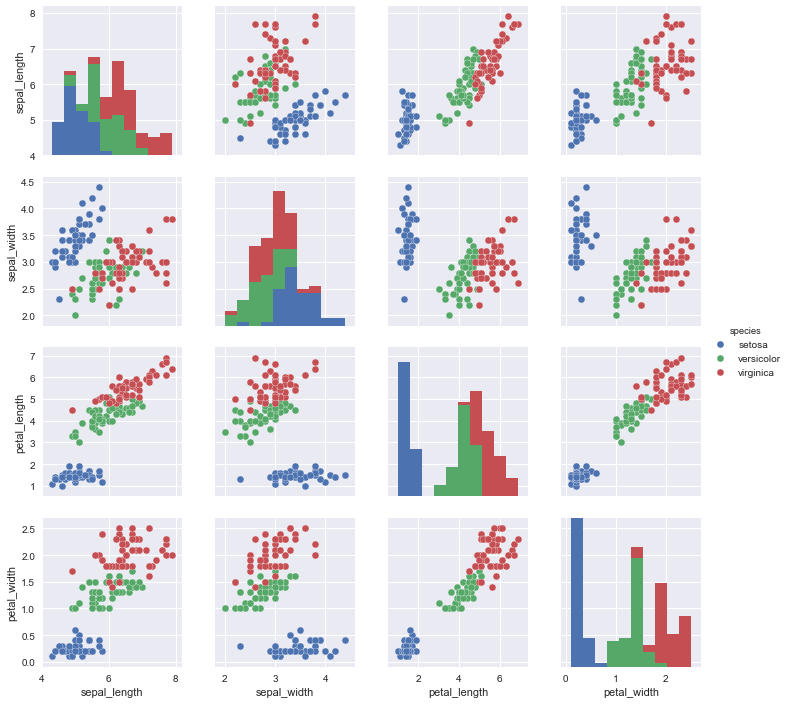

In [11]:
sns.pairplot(iris, hue="species");

In [12]:
iris_dummies = pd.get_dummies(iris, columns =['species'])

In [1008]:
#iris_dummies.sample(5)
iris_dummies.head()

,sepal_length,sepal_width,petal_length,petal_width,species_setosa,species_versicolor,species_virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


In [1025]:
# sns.count brings some problems: the x label is not linear
# plt.figure(figsize=(10,7))
# sns.countplot(x='petal_length',hue='species_setosa',data=iris_dummies)

In [1054]:
def plot_histogram(my_species,feature,n_bins=20,normed=None,data=iris):
    """Plot a histogram of the given feature according to a given species."""
    iris_dummies  = pd.get_dummies(data, columns =['species'])
    grouped_my_species = iris_dummies.groupby('species_'+my_species)
    hist_my_species= [group[feature] for _,group in grouped_my_species]
    labels = [value for value,_ in grouped_my_species]
    sns.set_style("whitegrid")
    plt.figure(figsize=(10,7))
    plt.hist(hist_my_species, histtype='bar',bins=n_bins,normed=normed,label=labels);
    #plt.yticks([])
    plt.legend()
    plt.xlabel(feature)
    sns.despine()
    plt.title(my_species)

In [1055]:
# def plot_histogram(my_species,feature,n_bins=20,normed=None):
#     """Plot a histogram of the given feature according to a given species."""
#     grouped_my_species = iris_dummies.groupby('species_'+my_species)
#     hist_my_species= [group[feature] for _,group in grouped_my_species]
#     sns.set_style("whitegrid")
#     plt.figure(figsize=(10,7))
#     plt.hist(hist_my_species, histtype='bar',bins=n_bins,normed=normed,label=[my_species,'not '+my_species]);
#     #plt.yticks([])
#     plt.legend()
#     plt.xlabel(feature)
#     sns.despine()
#     plt.title(my_species)

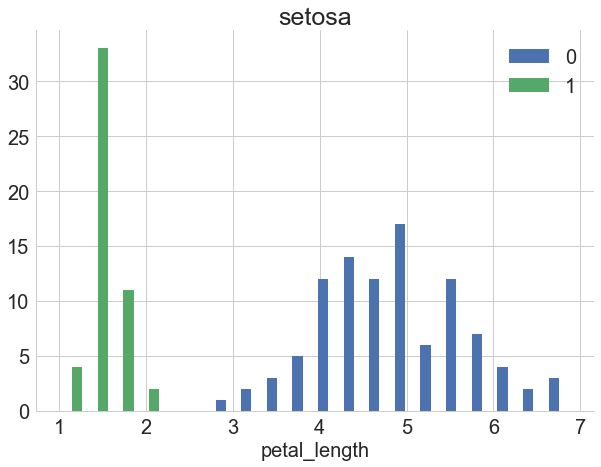

In [1056]:
plt.rc('legend', fontsize=20) 
plt.rc('font', size=22)  
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20) 
plt.rc('axes', labelsize=20) 
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plot_histogram('setosa','petal_length')

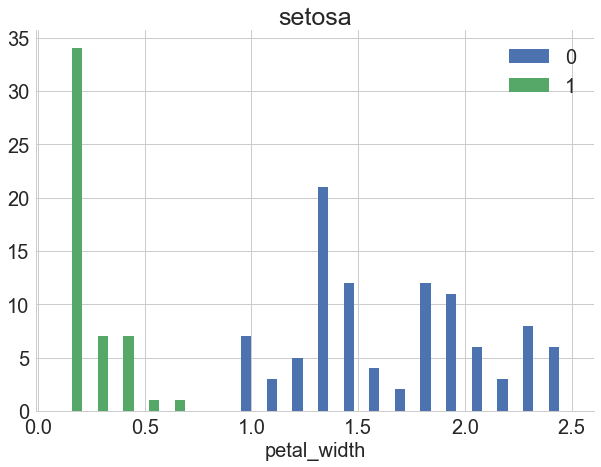

In [1023]:
plot_histogram('setosa','petal_width')

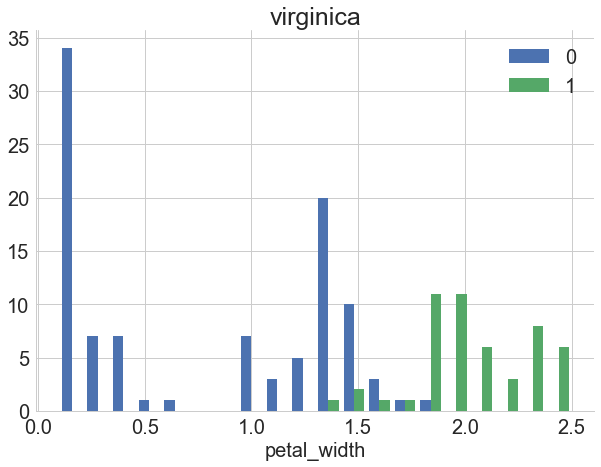

In [1024]:
plot_histogram('virginica','petal_width')

## Problem we want to address: knowing the petal width, predict if the iris is a virginica

# Logistic regression with sklearn: guessing virginica knowing the petal width

In [1043]:
x = iris['petal_width'].reshape(-1,1)
y= iris_dummies['species_virginica']

In [1044]:
import sklearn.model_selection
import sklearn.linear_model

In [1052]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x,y,test_size = 0.2)

In [1046]:
logistic_classifier = sklearn.linear_model.LogisticRegression()

In [1047]:
logistic_classifier.fit(x_train,y_train);

In [1048]:
print(logistic_classifier.coef_ , logistic_classifier.intercept_)

[[ 2.41250259]] [-3.77490477]


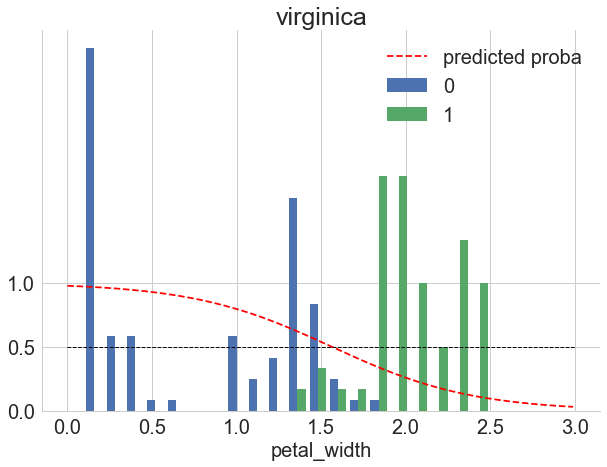

In [1057]:
plot_histogram('virginica','petal_width',normed=True)
domain_petal_width = np.arange(0,3,0.01)
predicted_proba = logistic_classifier.predict_proba(domain_petal_width.reshape(-1,1))[:,0]
plt.plot(domain_petal_width,predicted_proba,'r--',label='predicted proba')
plt.plot([0,3],[.5,.5],'k--',linewidth=1)
plt.legend()
plt.yticks([0,0.5,1]);

In [1059]:
score_train = logistic_classifier.score(x_train,y_train)
print(score_train)
# normally the score should be 0.958333 = 115/120
# knowing that there are 5 misclassified, on a total of 120=x_train.shape[0]

0.95


In [1060]:
prediction_train = logistic_classifier.predict_proba(x_train)
loss_train = sklearn.metrics.log_loss(y_train,prediction_train)
print(loss_train)

0.280110773967


In [1061]:
score_test = logistic_classifier.score(x_test,y_test)
print(score_test)

0.933333333333


In [1062]:
prediction_test = logistic_classifier.predict_proba(x_test)
test_loss = sklearn.metrics.log_loss(y_test,prediction_test)
print(test_loss)

0.275380896025


## The sigmoid function

Here the logistic regression algorithm does the following: try to find a function 
$$ P_{normal} : [0,100] \to [0,1]$$
such that for a random value of a coordinate $x \in [0,100]$,   

$ P_{normal}(x)$ is an estimate (= a guess) of the probability that the traffic is slow.

The idea of logistic regression is to look for a function of the form:
$$ P_{normal}(x) = \sigma(wx+b)$$
where 
$$\sigma : \mathbb{R} \to [0,1]$$ is the **sigmoid function ** defined by 
$$ \sigma(x) = \frac{1}{1+e^{-x}}$$

In [1063]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

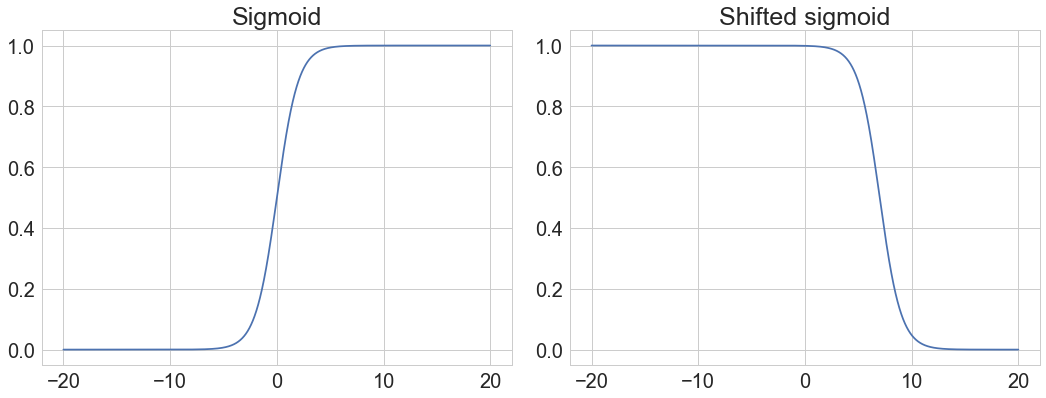

In [1078]:
plt.figure(figsize=(15,6))

plt.subplot(121)
x_sigmoid = np.arange(-20,20,0.01)
y_sigmoid = sigmoid(x_sigmoid)
_ = plt.plot(x_sigmoid,y_sigmoid)
plt.title('Sigmoid')
plt.subplot(122)
w = -1
b = 7
y_shifted = sigmoid(w*x_sigmoid + b)
_ = plt.plot(x_sigmoid,y_shifted)
plt.title('Shifted sigmoid')
plt.tight_layout()

# Meshgrid heatplot

In [528]:
# dx, dy = 0.05, 0.05
# y, x = np.mgrid[slice(1, 5 + dy, dy),
#                 slice(1, 5 + dx, dx)]

In [532]:
def get_loss(weigth,bias,x,y,C=1.):
    """Compute the loss function."""
    model = sklearn.linear_model.LogisticRegression()
    model.coef_ = np.array([[weigth]])
    model.intercept_ = np.array([[bias]])
    pred = model.predict_proba(x)[:,1]
    #print(pred)
    log_loss = x.shape[0]*sklearn.metrics.log_loss(y,pred)
    #print(log_loss)
    loss = 0.5*(weigth**2 + bias**2) + C*log_loss
    return loss

def get_loss1(weigth,bias):
    return get_loss(weigth,bias,x_train,y_train,1.)
vloss = np.vectorize(get_loss1)

def get_meshgrid(xstart,xend,xstep,ystart,yend,ystep):
    xx,yy = np.mgrid[xstart:xend:xstep,ystart:yend:ystep]
    return xx,yy

In [552]:
xx,yy = get_meshgrid(0,5,.1,-10,0,.1)

In [553]:
loss = vloss(xx,yy)

Text(0,0.5,'bias')

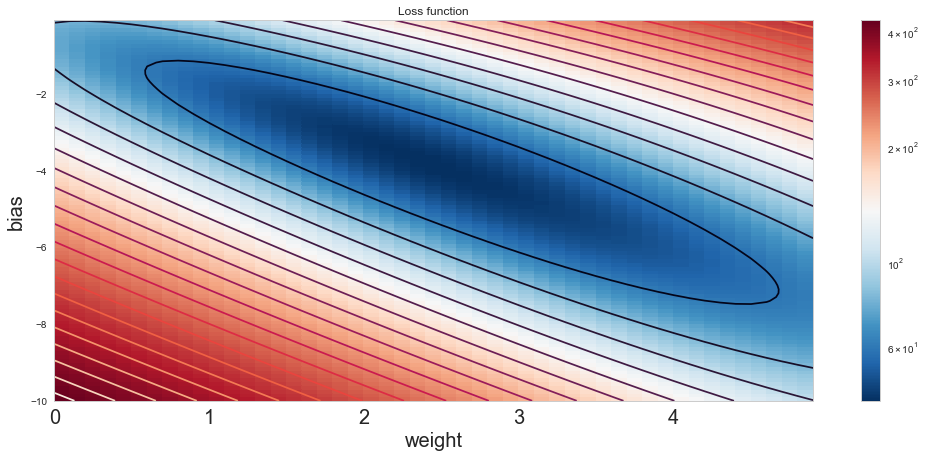

In [563]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(17,7))
#plt.pcolor(xx,yy,loss,cmap='RdBu_r')
plt.pcolor(xx,yy,loss,norm=colors.LogNorm(),cmap='RdBu_r')
plt.colorbar()
CS = plt.contour(xx, yy, loss,20)
plt.title('Loss function')
plt.xlabel('weight')
plt.ylabel('bias')

#plt.plot([-0,40],[-0*(-1.7),40*(-1.7)],'w--')

In [558]:
# plt.figure(figsize=(15,7))
# #plt.pcolor(xx,yy,l,norm=colors.LogNorm(),cmap='RdBu_r')
# # plt.pcolor(xx,yy,loss,cmap='RdBu_r')
# # plt.colorbar()
# #plt.plot([-0,40],[-0*(-1.7),40*(-1.7)],'w--')
# CS = plt.contour(xx, yy, loss,50)
# plt.clabel(CS, inline=1, fontsize=10)

In [538]:
idx = np.argmin(loss)
print(xx.flatten()[idx],yy.flatten()[idx])

2.35 -3.8


# Optimization, gradient descent with Keras

In [932]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.models import Model
from keras import optimizers
from keras import regularizers

In [976]:
model = Sequential()
model.add(Dense(1,input_dim=1,kernel_regularizer=regularizers.l2(.1)))
model.add(Activation('sigmoid'))

In [977]:
sgd = optimizers.SGD(lr=0.05)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [978]:
weight = 4
bias = 4
layer =  model.layers[0]
layer.set_weights( [ np.array([[weight]]) , np.array([bias]) ] ) 

In [ ]:
def initialise_keras_model(initial_weight = 4,initial_bias = 4):
    model = Sequential()
    model.add(Dense(1,input_dim=1,kernel_regularizer=regularizers.l2(.1)))
    model.add(Activation('sigmoid'))
    sgd = optimizers.SGD(lr=0.05)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    initial_weight = 4
    initial_bias = 4
    layer =  model.layers[0]
    layer.set_weights( [ np.array([[initial_weight]]) , np.array([initial_bias]) ] ) 
    return model

In [972]:
#history = model.fit(x_train,y_train,epochs=10,verbose=0)
# model.get_weights()
# loss = model.evaluate(x_train,y_train,verbose=0)[0]
# model.test_on_batch(x_train,y_train)
# model.train_on_batch(x_train,y_train)
# model.get_weights()

In [979]:
def get_loss(model,weight,bias,x,y,C=1.):
    """Compute the loss function."""
#     model = sklearn.linear_model.LogisticRegression()
#     model.coef_ = np.array([[weigth]])
    layer =  model.layers[0]
    layer.set_weights( [ np.array([[weight]]) , np.array([bias]) ] ) 
    loss = model.evaluate(x,y,verbose=0)[0]
    #print(pred)
    #log_loss = x.shape[0]*sklearn.metrics.log_loss(y,pred)
    #print(log_loss)
    #loss = 0.5*(weigth**2 + bias**2) + C*log_loss
    return loss

def get_loss1(weigth,bias):
    return get_loss(model,weigth,bias,x_train,y_train,1.)

vloss = np.vectorize(get_loss1)

def get_meshgrid(xstart,xend,xstep,ystart,yend,ystep):
    xx,yy = np.mgrid[xstart:xend:xstep,ystart:yend:ystep]
    return xx,yy

In [980]:
xx,yy = get_meshgrid(-10,10,.1,-10,10,.1)
loss_grid = vloss(xx,yy)

In [981]:
import pickle
with open('../data/loss_grid', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(loss_grid, f)

In [985]:
# with open('../data/loss_grid', 'rb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     loss_grid =pickle.load(f)

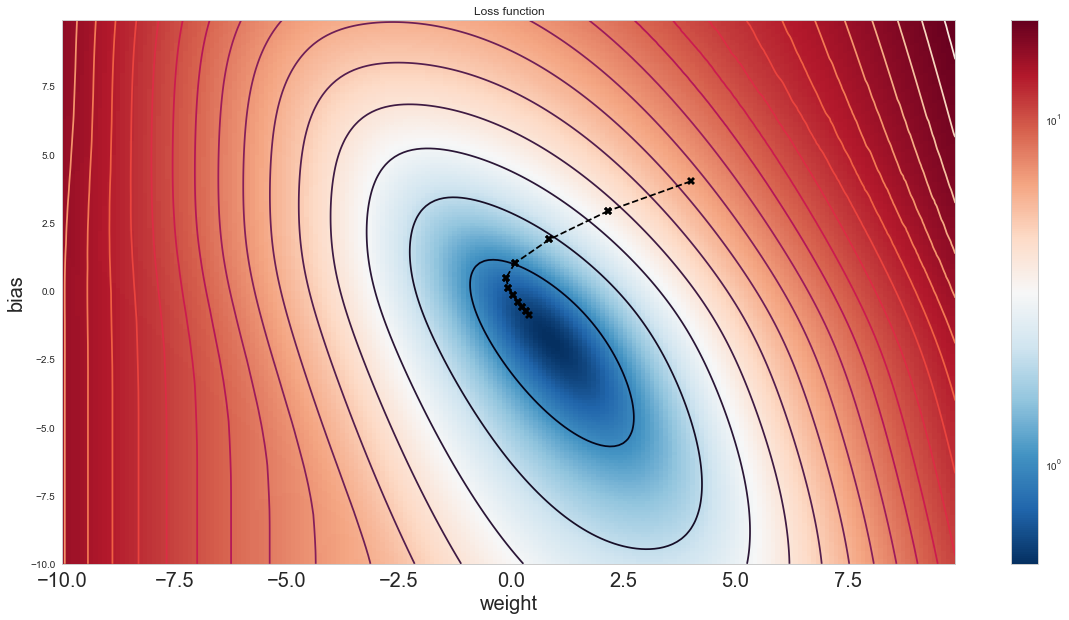

In [989]:
model = initialise_keras_model()
steps = 10
import matplotlib.colors as colors
fig = plt.figure(figsize=(20,10))
#plt.pcolor(xx,yy,loss,cmap='RdBu_r')
plt.pcolor(xx,yy,loss_grid,norm=colors.LogNorm(),cmap='RdBu_r')
plt.colorbar()
CS = plt.contour(xx, yy, loss_grid,20)
plt.title('Loss function')
plt.xlabel('weight')
plt.ylabel('bias')
for i in range(steps):
    old_weight, old_bias = model.get_weights()[0][0][0], model.get_weights()[1][0]
    model.fit(x_train,y_train,verbose=0,epochs = 8)
    weight, bias = model.get_weights()[0][0][0], model.get_weights()[1][0]
    plt.plot([old_weight,weight],[old_bias,bias],'kX--',markersize=8)


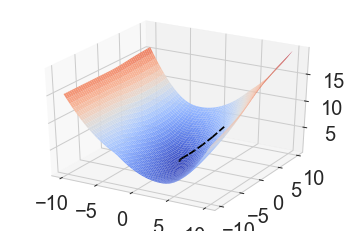

In [990]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,loss_grid,cmap=cm.coolwarm)

model = initialise_keras_model()
steps = 10
for i in range(steps):
    old_weight, old_bias = model.get_weights()[0][0][0], model.get_weights()[1][0]
    old_loss =model.evaluate(x_train,y_train,verbose=0)[0]
    model.fit(x_train,y_train,verbose=0,epochs = 5)
    weight, bias = model.get_weights()[0][0][0], model.get_weights()[1][0]
    new_loss = model.evaluate(x_train,y_train,verbose=0)[0]
    plt.plot([old_weight,weight],[old_bias,bias],[old_loss,new_loss],'k--',markersize=8)

# Logistic regression with Keras

In [571]:
model = Sequential()
model.add(Dense(1,input_dim=1,kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('sigmoid'))

In [572]:
# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [574]:
model.fit(x_train,y_train,epochs=10, batch_size=64,verbose=0)

# Neural Networks: when linear methods are not sufficient

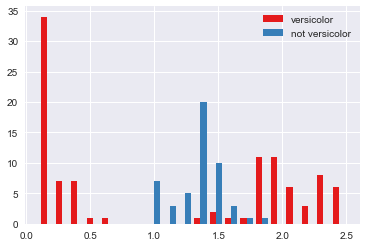

In [101]:
plot_histogram('versicolor','petal_width')

In [102]:
# for name,group in grouped:
#     print(name)
#     print(group)

In [87]:
# plt.figure(figsize=(10,7))
# sns.barplot(x='petal_length',hue='species_setosa',data=iris_dummies)

In [ ]:
colors = ['red', 'blue']
plt.hist(x, n_bins, normed=1, histtype='bar', color=colors, label=colors)

# Playground

In [744]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, InputLayer

model = Sequential([
    InputLayer([10]),
    Dense(1)
])
model.trainable = True
model.compile("adam", "mse")

x = np.random.uniform(-1, 1, [8, 10])
y = np.random.uniform(-1, 1, [8])

print(model.train_on_batch(x, y))
print(model.test_on_batch(x, y))
print(model.test_on_batch(x, y))
print(model.train_on_batch(x, y))
print(model.train_on_batch(x, y))

print(model.test_on_batch(x, y))
print(model.train_on_batch(x, y))
print(model.test_on_batch(x, y))

1.38948
1.38427
1.38427
1.38427
1.37908
1.3739
1.3739
1.36873
